# Bulk CRISPR screen sample / guide quality report

Examine the quality of the guide and samples and masks the low-quality guides and samples.

In [1]:
import pandas as pd
import anndata as ad
import perturb_tools as pt
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
plt.style.use('default')

## Load data

Load data from `bulk/basic_api_demo.ipynb`.

In [4]:
screen_path = "HeLa_lib1.h5ad"
screen = ad.read_h5ad(screen_path)

If you don't have the file, below snippet creates screen object.

In [28]:
! wget -nc http://tko.ccbr.utoronto.ca/Data/readcount-HeLa-lib1.gz
! gunzip readcount-HeLa-lib1.gz -f

def make_anndata(tbl):
  sample_df = pd.DataFrame(tbl.columns[2:]).rename(columns={0:"sample"}).set_index("sample")
  sample_df["replicate"] = sample_df.index.str[-1]
  sample_df["time"] = sample_df.index.str[1:-1].map(lambda s: int(s) if s else -1)
  return ad.AnnData(X=tbl.values[:,2:].T, dtype=int, var=tbl.iloc[:,:2].set_index("GENE_CLONE"), 
                   obs=sample_df)

tbl = pd.read_csv("readcount-HeLa-lib1", sep = "\t")
screen = make_anndata(tbl)

--2023-04-11 16:31:22--  http://tko.ccbr.utoronto.ca/Data/readcount-HeLa-lib1.gz
Resolving tko.ccbr.utoronto.ca (tko.ccbr.utoronto.ca)... 142.150.76.126
Connecting to tko.ccbr.utoronto.ca (tko.ccbr.utoronto.ca)|142.150.76.126|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2877516 (2.7M) [application/x-gzip]
Saving to: ‘readcount-HeLa-lib1.gz’

100%[======================================>] 2,877,516   1.86MB/s   in 1.5s   

2023-04-11 16:31:24 (1.86 MB/s) - ‘readcount-HeLa-lib1.gz’ saved [2877516/2877516]



Annotate unannotated samples & log-normalize guides

In [7]:
pt.pp.log_norm(screen)

## Sample quality

### Visualize quality metrics

#### Per-sample guide coverage

<Axes: xlabel='# guides', ylabel='Count'>

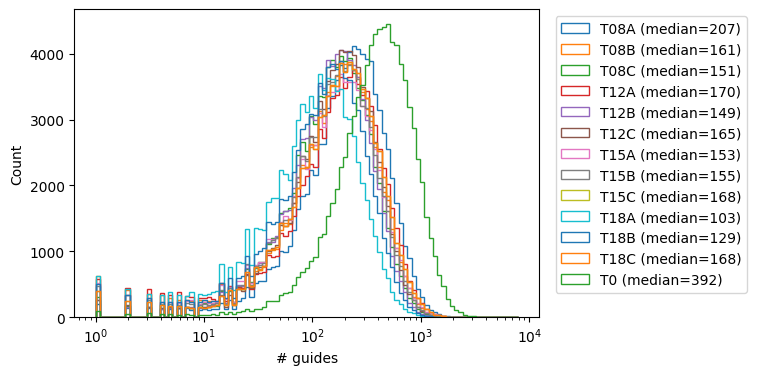

In [8]:
pt.pl.sample_count_dist(screen, figsize=(6,4))

#### Per-sample guide coverage uniformity

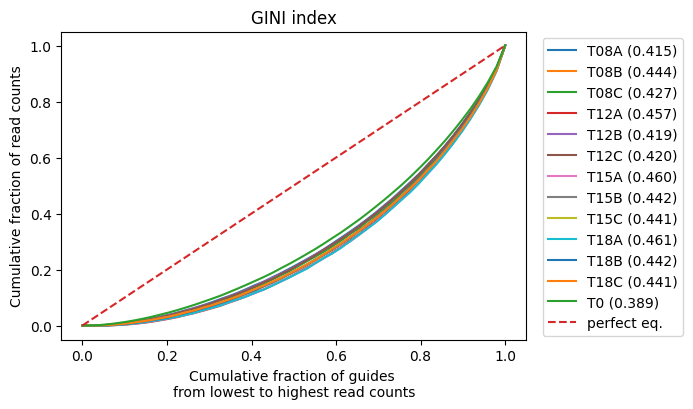

In [9]:
pt.pl.sample_count_gini(screen, figsize=(6,4))

#### Guide count correlation

Plotting functions support `args` and `kwargs` for base pyplot or seaborn functions.

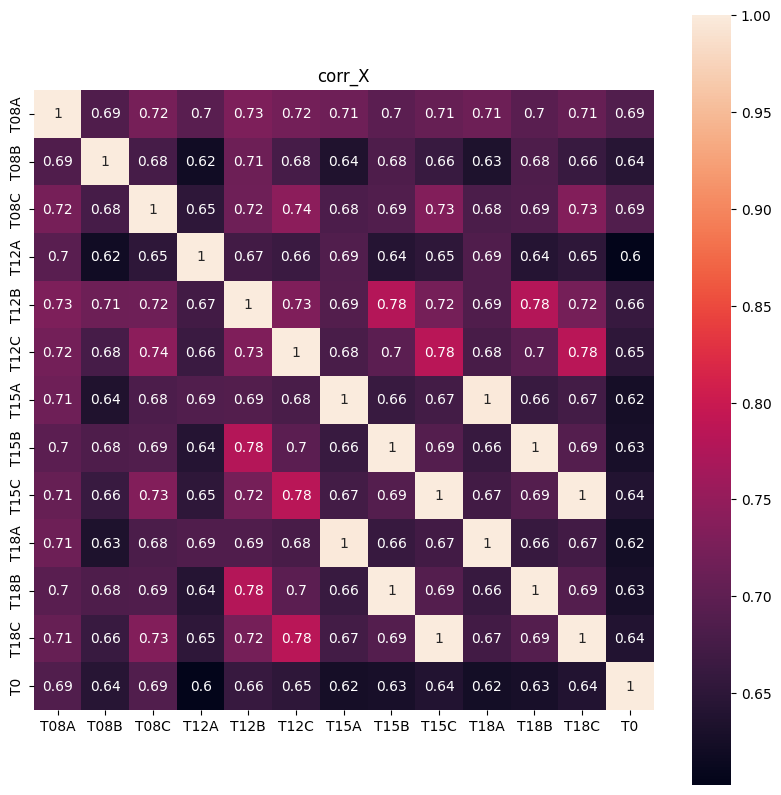

In [10]:
pt.pl.sample_count_correlation(screen, annot=True)

#### LFC correlation of positive controls

In [11]:
screen_t = screen[screen.obs.replicate != "0",:]

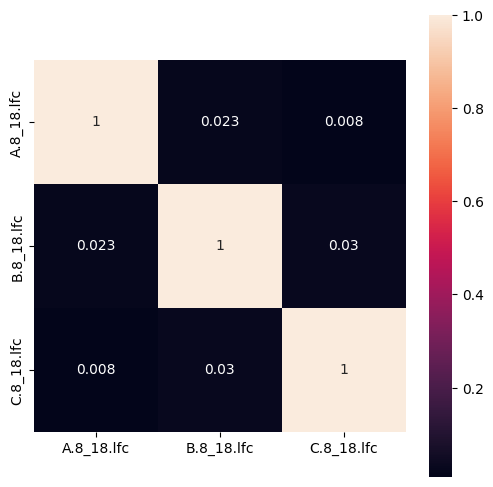

In [12]:
lfcs, ax = pt.pl.sample_lfcs_correlation(screen_t, method="spearman", cond1=8, cond2=18, rep_col="replicate", cond_col = "time",)

If you have the label for positive control guide, you can subset those to plot.

In [13]:
! wget -nc http://tko.ccbr.utoronto.ca/Data/core-essential-genes-sym_HGNCID

File ‘core-essential-genes-sym_HGNCID’ already there; not retrieving.



In [14]:
posctrl_genes = pd.read_csv("core-essential-genes-sym_HGNCID", header=None, sep="\t").values[:,0]

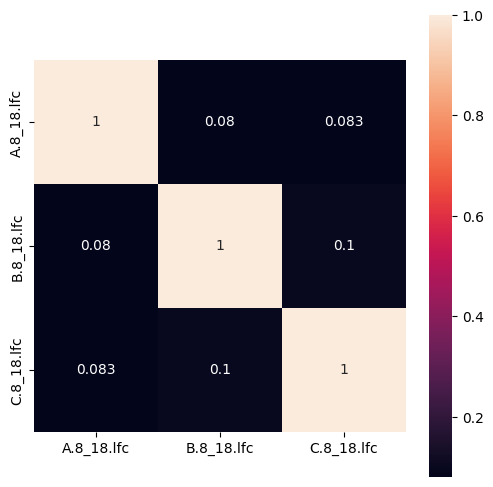

In [15]:
lfcs, ax = pt.pl.sample_lfcs_correlation(screen_t, guide_idx = screen_t.var.GENE.isin(posctrl_genes), method="spearman", cond1=8, cond2=18, rep_col="replicate", cond_col = "time",)

## Identify outlier guides

Outlier guides can be identified per experimental condition based on Median Absolute Deviance & RPM threshold.  
Below script identifies outlier guides both with MAD |z| > 3 and RPM > 10000.

In [26]:
outlier_guides = pt.qc.get_outlier_guides(screen, condit_col = "time", mad_z_thres=3, abs_RPM_thres=10000)

In [27]:
outlier_guides

,GENE_CLONE,sample,RPM
